# Psychophysiological Interactions

Code modified from https://dartbrains.org/content/Connectivity.html (Written by Luke Chang)

Demo for 1 subject, 1 run for now. 

Also, only focus on EMbias trials (2-back lexical decisions and a large set of trial-unique heterogeneous pictures)

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data, Design_Matrix, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import zscore, fdr, one_sample_permutation
from nltools.file_reader import onsets_to_dm
from nltools.plotting import component_viewer
from scipy.stats import binom, ttest_1samp
from sklearn.metrics import pairwise_distances
from copy import deepcopy
import networkx as nx
from nilearn.plotting import plot_stat_map, view_img_on_surf
from bids import BIDSLayout, BIDSValidator
import nibabel as nib


/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
base_dir = '/Users/TienTong/Desktop/utdallas_demo/'
data_dir = os.path.join(base_dir, 'data')
layout = BIDSLayout(data_dir, validate=False, derivatives='/Users/TienTong/Desktop/utdallas_demo/fmriprep/fmriprep')

subject = '01'
fwhm=6

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


# View raw data

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


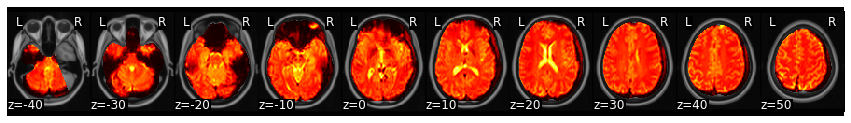

In [3]:
# Compute the voxel_wise mean of functional images across time.
raw = Brain_Data(layout.get(subject=subject, task='em', scope='raw', suffix='bold', extension='nii.gz', return_type='file')[0])
mean_raw = raw.mean()

raw.mean().plot()


# Get Preprocessed Data then Smooth

Data was preprocessed with fMRIPrep


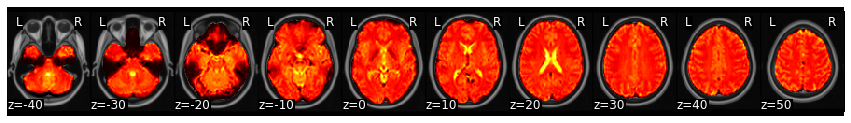

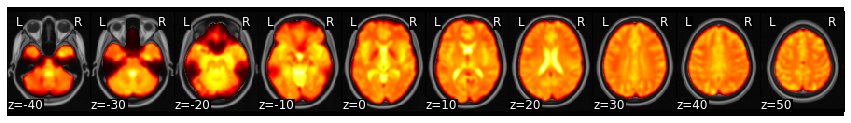

In [4]:
data = Brain_Data(layout.get(subject=subject, task='em', scope='derivatives', suffix='bold', extension='nii.gz', return_type='file')[0])
smoothed = data.smooth(fwhm=fwhm)
tr = layout.get_tr()
n_tr = len(data)


data.mean().plot()
smoothed.mean().plot()

# Create Hippocampus mask then extract BOLD from mask

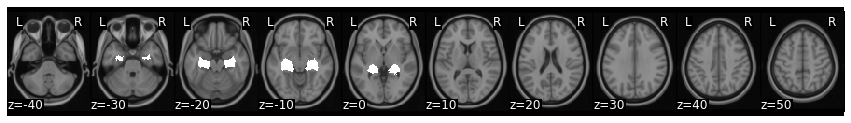

In [5]:
mask = Brain_Data('https://neurovault.org/media/images/8423/k50_2mm.nii.gz')
mask_x = expand_mask(mask)

# Index of Hippocampus is 28, more info here: https://neurovault.org/images/395092/
f = mask_x[28].plot()

Text(0.5, 1.0, 'Hippocampus BOLD Timeseries')

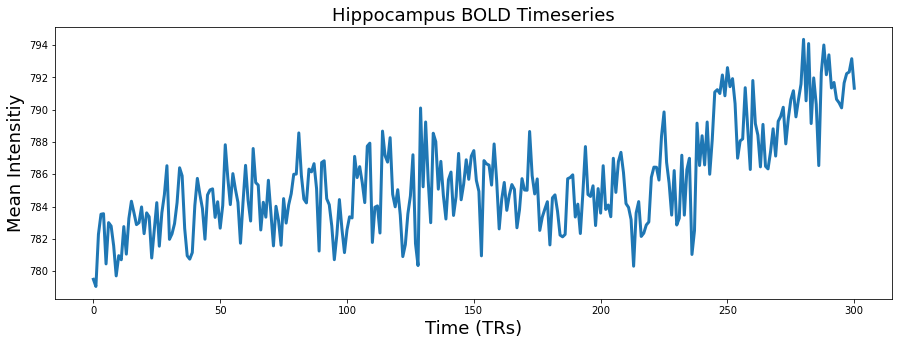

In [6]:
hippo = smoothed.extract_roi(mask=mask_x[28])

plt.figure(figsize=(15,5))
plt.plot(hippo, linewidth=3)
plt.ylabel('Mean Intensitiy', fontsize=18)
plt.xlabel('Time (TRs)', fontsize=18)
plt.title('Hippocampus BOLD Timeseries', fontsize=18)

# Seed Voxel Correlations - no interaction with task (yet)

Nuisance regressors:

   * The normalized hippo signal
   * The normalized average activity in CSF 
   * 24 motion covariates
   * linear and quadratic trends 

Note: Need to be a little careful about filtering as the normal high pass filter for an event related design might be too short and will remove potential signals of interest.


In [7]:
def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)


hippo = zscore(pd.DataFrame(hippo, columns=['hippo']))

csf_mask = Brain_Data(os.path.join(base_dir, 'fmriprep/fmriprep/sub-01/anat/sub-01_space-MNI152NLin6Asym_res-2_label-CSF_probseg.nii.gz'))
csf_mask = csf_mask.threshold(upper=0.7, binarize=True)
csf = zscore(pd.DataFrame(smoothed.extract_roi(mask=csf_mask).T, columns=['csf']))

spikes = smoothed.find_spikes(global_spike_cutoff=3, diff_spike_cutoff=3)
covariates = pd.read_csv(layout.get(subject=subject, scope='derivatives', extension='.tsv')[0].path, sep='\t')
mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
mc_cov = make_motion_covariates(mc, tr)
dm = Design_Matrix(pd.concat([hippo, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

dm.columns


Index(['hippo', 'csf', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y',
       'rot_z', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
       'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'trans_x',
       'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'diff_spike1',
       'diff_spike2', 'diff_spike3', 'diff_spike4', 'diff_spike5',
       'diff_spike6', 'diff_spike7', 'diff_spike8', 'poly_0', 'poly_1',
       'poly_2'],
      dtype='object')

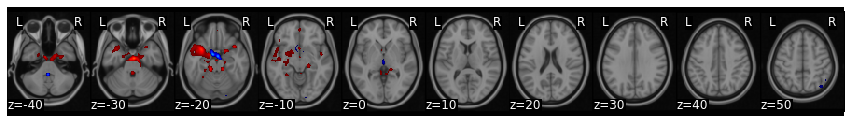

In [8]:
smoothed.X = dm
stats = smoothed.regress()

hippo_conn = stats['beta'][0]
hippo_conn.threshold(upper=5, lower=-5).plot() 


# Psychophysiological Interactions

Testing the connectivity between Hippcampus and other regions in different conditions:
   * Prospective memory (PM) for face
   * PM for scene
   * 2-back lexical decision
   
**New design matrix**: Includes:
   * All nuisance regressors included in the previous design
   * Add the 3 task regressors 
   * Add interaction terms between each task regressors and hippocampus seed activity 

In [9]:
def load_bids_events(layout, subject):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    n_tr = nib.load(layout.get(subject=subject, scope='raw', suffix='bold', extension='nii.gz')[0].path).shape[-1]

    onsets = pd.read_csv(layout.get(subject=subject, suffix='events')[0].path, sep='\t')
    onsets = onsets[['onset', 'duration', 'categ']]
    onsets.rename(columns={'onset': 'Onset', 'duration': 'Duration', 'categ': 'Stim'}, inplace=True)

    return onsets_to_dm(onsets, sampling_freq=1/tr, run_length=n_tr)

dm = load_bids_events(layout, subject)
dm_conv = dm.convolve()
dm_conv['hippo'] = hippo
dm_conv['hippo_face'] = dm_conv['hippo']*dm_conv['face_c0']
dm_conv['hippo_scene'] = dm_conv['hippo']*dm_conv['scene_c0']
dm_conv['hippo_lexdec'] = dm_conv['hippo']*dm_conv['lexdec_c0']

dm = Design_Matrix(pd.concat([dm_conv, csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
dm = dm.add_poly(order=2, include_lower=True)

/Users/TienTong/opt/anaconda3/lib/python3.8/site-packages/nltools/file_reader.py:140: UserWarning: Computed onsets for scene are inconsistent with expected values. Please manually verify the outputted Design_Matrix!
  warnings.warn(


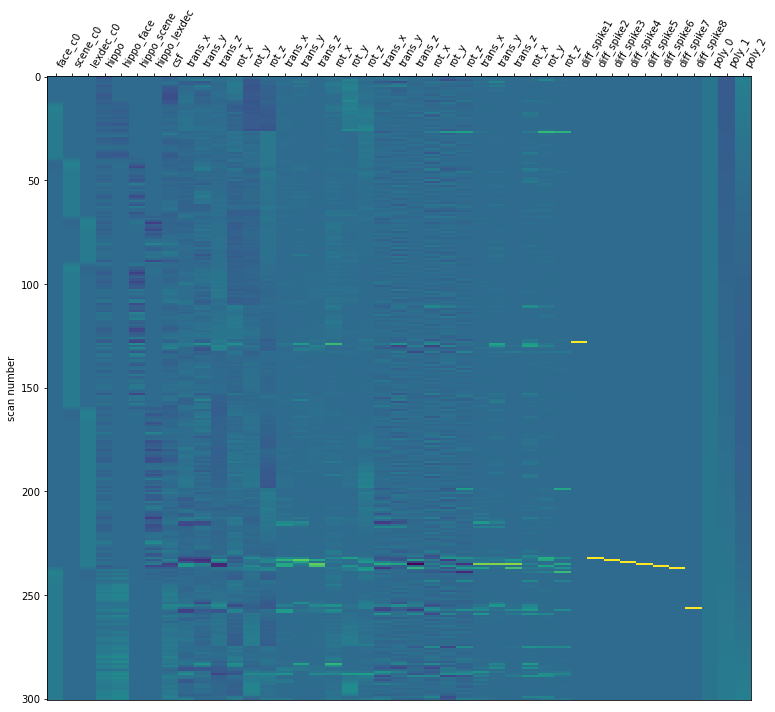

In [10]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(dm)
import matplotlib.pyplot as plt
plt.show()

# Hippocampal connectivity during Face Prospective Memory

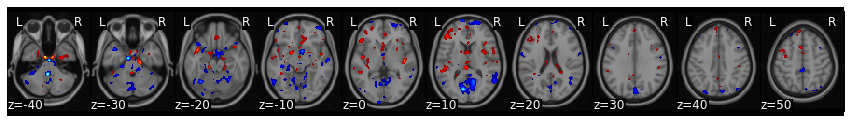

In [11]:
smoothed.X = dm
ppi_stats = smoothed.regress()

hippo_face_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='hippo_face')[0][0])]
hippo_face_ppi.threshold(upper=5, lower=-5).plot()


# Hippocampal connectivity during Scene Prospective Memory

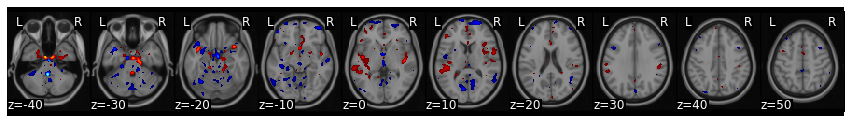

In [12]:
hippo_scene_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='hippo_scene')[0][0])]
hippo_scene_ppi.threshold(upper=5, lower=-5).plot()

# Hippocampal connectivity during Lexical Decision (2-back)

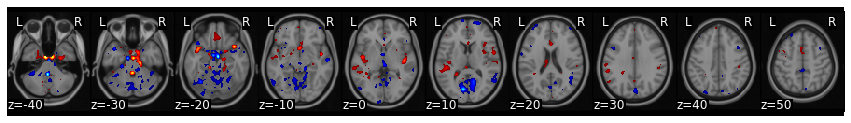

In [13]:
hippo_lexdec_ppi = ppi_stats['beta'][int(np.where(smoothed.X.columns=='hippo_lexdec')[0][0])]
hippo_lexdec_ppi.threshold(upper=5, lower=-5).plot()